<a href="https://colab.research.google.com/github/Benni-Kang/AI_CorseProject/blob/main/pa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP7015: Artificial Intelligence *(Semester 1, 2022/23)*

# Programming Assignment 2

**Instructions:**
1. Fill in your name and student id in the following cell.
2. Write all you codes in this jupyter notebook.
3. You can define your own functions, methods, classes, and variables as you need.
4. Please name your functions and variables in a clear and concise way to maximize the redability of your codes.
5. Name your jupyter notebook in the format of `pa2_<student id>.ipynb` and submit it in Moodle. For example, `pa2_16483715.ipynb`.
6. What you write in this notebook must be your own input. Copying from others and online resources are subject to heavy penalty. Lending and borrowing assignment solutions are both regarded as dishonest behaviours and are subject to heavy penalty and disciplinary actions.

In [ ]:
# Fill in your name and student ID
name = 'NieYixin'
student_id = '22425918'

# Q1. Handwritten letter recognition with MLP (50 marks)

In this task, you are required to define and train an MLP model for the handwritten letter recognition task. We use the `EMNIST` dataset. See [[its Readme file]](https://www.westernsydney.edu.au/__data/assets/text_file/0019/1204408/EMNIST_Readme.txt) for a detailed description. We provide you with the following code block to load the dataset.

In this dataset, there are 124,800 images for training and 20,800 images for testing. Each image corresponds to one of the 26 English letters.

In [ ]:
import torch

import torch.nn as nn

import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

from matplotlib import pyplot as plt

In [ ]:
# Some transformation are needed.
emnist_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),  # rotates the image by 90 degree
    lambda img: transforms.functional.hflip(img),  # flip the image horizontally
    transforms.ToTensor()
])

# The dataset can be loaded using the Pytorch function as below
emnist_train = EMNIST('./', train=True, download=True, split='letters', 
                      transform=emnist_transform,
                      target_transform=lambda x: x-1)
emnist_test = EMNIST('./', train=False, download=True, split='letters', 
                     transform=emnist_transform,
                     target_transform=lambda x: x-1)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
len(emnist_train)

124800

A visualization of the dataset can be done as follows. It gives you an intuition about the dataset we are working with.

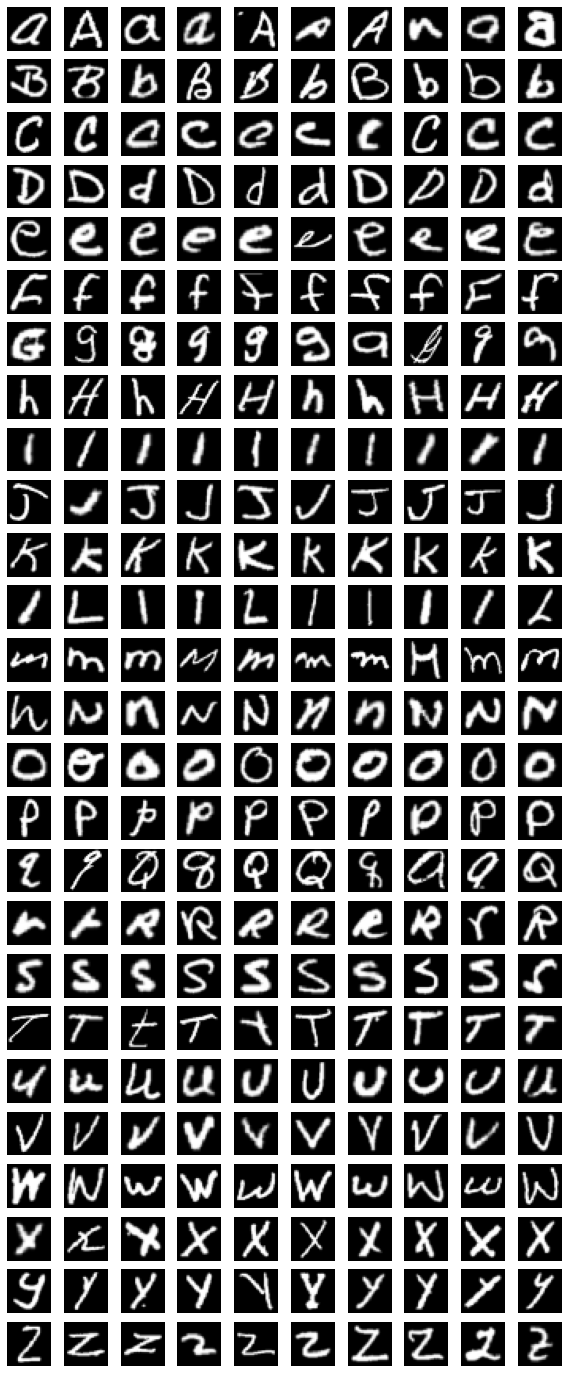

In [ ]:
_, labels = zip(*emnist_train)
indices = [[i for i in range(len(labels)) if labels[i]==c] for c in range(26)]

fig, ax = plt.subplots(26, 10, figsize=(10, 25))
for c in range(26):
    for i in range(10):
        ax[c][i].imshow(emnist_train[indices[c][i]][0][0].numpy(), cmap='gray')
        ax[c][i].axis('off')
plt.show()

## (a) Define an MLP model to recognize the handwritten letters. Use three hidden layers for this MLP and the hidden sizes of the three hidden layers are 256, 512, and 512, respectively. Use ReLU as the activation function. (15 marks)

In [ ]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 256) #input + h1
        self.linear1 = torch.nn.Linear(256, 512) #h1+h2
        self.linear2 = torch.nn.Linear(512, 512) #h2+h3
        self.linear3 = torch.nn.Linear(512, output_dim) #h3+output

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = F.relu(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        output = self.linear3(x)
        return output


## (b) Train an MLP model to recognize the handwritten letters. The following aspects should be covered in your answers.
1. The full pipeline of training such a model. (15 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (10 marks)
2. Compute the accuracy for the test set. (10 marks)

In [ ]:
"""1. Load datasets"""

data_transform = transforms.Compose([
    transforms.ToTensor()
    ])  # since the mean and std are not give, we skip the normalization.

# if you want to compute the mean & std and do the normalization, 
# see https://androidkt.com/calculate-mean-and-std-for-the-pytorch-image-dataset/
# for a reference.


train_loader = torch.utils.data.DataLoader(emnist_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(emnist_test, batch_size=128, shuffle=False)

"""2. Create an instance of the MLP model and the optimizer"""
mlp = MLP(28*28, 26)

optimizer = torch.optim.SGD(mlp.parameters(),
                            lr=0.1,
                            weight_decay=0.0001,
                            momentum=0.8)

"""3. Define the loss function to use."""
loss = torch.nn.CrossEntropyLoss()

"""4. Do training"""
mlp.train()  # set to training mode

iters = 0   # total number of iterations
acc = 0
for epoch in range(2):
  while(acc<=0.95):
    for i, data in enumerate(train_loader):
      
        iters += 1
        image, label = data
        optimizer.zero_grad()  # reset gradient of parameters to be optimzied
    
        output = mlp(image)  # forward pass: generate prediction
        new_loss = loss(output, label)  # forward pass: compute loss
        new_loss.backward()  # backward pass: compute gradients
        optimizer.step()  # update parameters
        
        output_class = output.argmax(dim=1)
        correct_samples = (output_class == label).sum().item()
        acc = correct_samples / label.shape[0]

        if iters % 100 == 0:
            print(f"Iteration: {iters}, loss is : {new_loss.item()}, Acc for this batch: {acc:.3f}")
        
        
        if  acc>0.95:
            print(f"-----Iteration: {iters}, loss is : {new_loss.item()}, Acc for this batch: {acc:.3f},we early stop.")
            break



        



Iteration: 100, loss is : 1.3506417274475098, Acc for this batch: 0.586
Iteration: 200, loss is : 1.176605463027954, Acc for this batch: 0.664
Iteration: 300, loss is : 0.6003636717796326, Acc for this batch: 0.758
Iteration: 400, loss is : 0.5909789204597473, Acc for this batch: 0.805
Iteration: 500, loss is : 0.4909282326698303, Acc for this batch: 0.867
Iteration: 600, loss is : 0.6201189756393433, Acc for this batch: 0.797
Iteration: 700, loss is : 0.518543004989624, Acc for this batch: 0.867
Iteration: 800, loss is : 0.3599044680595398, Acc for this batch: 0.867
Iteration: 900, loss is : 0.4325769543647766, Acc for this batch: 0.859
Iteration: 1000, loss is : 0.3229369819164276, Acc for this batch: 0.859
Iteration: 1100, loss is : 0.30024439096450806, Acc for this batch: 0.906
-----Iteration: 1198, loss is : 0.23224875330924988, Acc for this batch: 0.961,we early stop.


# Q2. Basics of Convolutional Neural Network (30 marks)

## (a) Complete the function below to compute the convolution given an `input_tensor` (a two-dimensional tensor), a `kernel_tensor` and a `stride_size`. For simplicity, we only consider gray scale images. The function should return the output after doing convolution. The followings are expected. (20 marks)
1. The function correctly computes the convolution. (10 marks)
2. The function correctly handles different stride sizes. (5 marks)
3. The function output has the the same size as the input by using padding. (5 marks) 

**Hint**: the padding size can be computed using the equation given in lectures that computes the output size of the convolution.

In [ ]:
import math

In [ ]:
def convolution(input_tensor, kernel_tensor, stride_size):
  # Given the size of input\kernel\stride, in order to get the same size of output, 
  # assuming all these shape are square, so that (heigh = wide) 
  # then we could use len() to record heigh and wide
  size_n = len(input_tensor)
  size_k = len(kernel_tensor)

  size_p = math.ceil(0.5*((size_n-1)*stride_size+size_k-size_n))

  # padding the input_tensor
  zeropad = nn.ZeroPad2d(padding=(size_p,size_p,size_p,size_p))
  input_pad = zeropad(input_tensor)

  output = torch.zeros([size_n,size_n])

  for i in range(size_n):
    for j in range(size_n):
      temp = input_pad[i*stride_size:i*stride_size+size_k, j*stride_size:j*stride_size+size_k]
      # print(temp)
      temp_mul = torch.mul(temp,kernel_tensor)
      # print(temp_mul)
      output[i][j] = temp_mul.sum()

  return output

##### The following code blocks are examples of calling this function. Do NOT modify them.

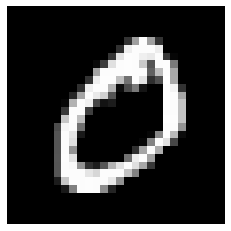

In [ ]:
# load in an image
img = torch.load('./img.pt')
plt.imshow(img.numpy(), cmap='gray')
plt.axis('off')

# define a kernel
kernel = torch.FloatTensor([
    [-1, -1, -1],
    [1, 1, 1],
    [0, 0, 0]
])

In [ ]:
print(img.shape)

torch.Size([28, 28])


(-0.5, 27.5, 27.5, -0.5)

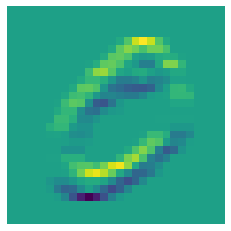

In [ ]:
# An example of calling your function
output = convolution(img, kernel, stride_size=1)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

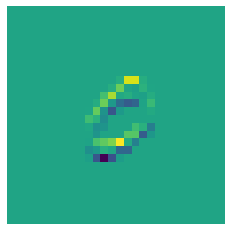

In [ ]:
# Another example
output = convolution(img, kernel, stride_size=2)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

## (b) Complete the function below to do the max pooling given `input tensor` (a two-dimensional tensor), a `kernel_size` and a `stride_size`.  (10 marks)

In [ ]:
def max_pooling(input_tensor, kernel_size, stride_size):
  # Given the size of input\kernel\stride, in order to get the same size of output, 
  # assuming all these shape are square, so that (heigh = wide) 
  # then we could use len() to record heigh and wide
  
  k=kernel_size
  size_n = len(input_tensor)

  opn = math.ceil(size_n/kernel_size) # output size: n
  print(opn)
  output = torch.zeros([opn,opn])


  for i in range(opn):
    for j in range(opn):
      temp = input_tensor[i*stride_size:i*stride_size+k, j*stride_size:j*stride_size+k]
      # print(temp)
      output[i][j] = temp.max()

  return output

##### The following code block is an example of calling this function. Do NOT modify it.

14


(-0.5, 13.5, 13.5, -0.5)

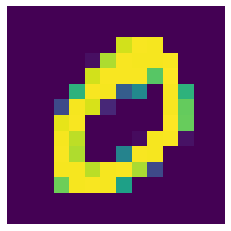

In [ ]:
output_pooling = max_pooling(img, kernel_size=2, stride_size=2)

plt.imshow(output_pooling.numpy())
plt.axis('off')

# Q3. Using Pretrained CV Models (20 marks)

In this question, we use a pretrained CV model and fine-tune it for a classification task. We use the ResNet model. Here is a detailed insruction about how to use it: https://pytorch.org/hub/pytorch_vision_resnet/.

The `torch.hub` module is a newer way to import and use pretrained models. The procedures of fine-tune it are the same as introduced in the lab session.

In [ ]:
# The pretrained model can be loaded by the following line and the corresponding data transform is given.

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# this shows you the architecture of the ResNet model.
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Hint**: As shown above, the last layer for classification in ResNet18 model is called `fc`.

## (a) Fine-tune the ResNet model for the handwritten letter recognition dataset (EMNIST) we used in Q1.  The followings are expected. (15 marks)

1. Build the full pipeline of fine-tuning the pretrained ResNet model. (5 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (5 marks)
2. Compute the accuracy for the test set. (5 marks)

In [ ]:
# We need to import some more modules for training/finetuning
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torchvision import models, transforms

In [ ]:
# First we creat an intance of the network to be finetuned
model_ft = models.resnet18(pretrained=True)

# "Freeze" the model by setting requires_grad to False for all parameters,
#   so that the gradients of all parameters will not be computed during 
#   backpropagation. By doing this, the model parameters will not be updated 
#   during finetuning.
for param in model_ft.parameters():
    param.requires_grad = False

# Recall our target: we would like to tweak the parameters of the last layer. 
#   So, let's replace it with a new layer. The last layer can be indexed by 6.
num_ftrs = model_ft.fc.in_features  # get input size to the final layer
# replace it with a new linear layer with ten output classes (CIFAR-10 dataset).
model_ft.fc = nn.Linear(num_ftrs, 10)

In [ ]:
# Construct training, validation, and test dataloaders. Dataloaders are objects 
#   that could yield data in a batch.

# We use 10k images for training and 3k validation set
train_set, val_set, _ = torch.utils.data.random_split(emnist_train, [74800, 7488, 42512])

train_loader =  DataLoader(train_set, batch_size=128)
validation_loader =  DataLoader(val_set, batch_size=128)

In [ ]:
# Detect if we have a GPU available. For Colab users, you can use GPU. The option
#   can be found in the meun `Runtime -> Change runtime type -> Hardware accelerator`
#   select GPU, then click "Save" button.

# Note that, 
#   - GPU is optional, but it will make the finetuning faster. Using only CPU is also good.
#   - If you change the runtime type, you will need to run the notebook from the first cell.
#      (you are allocated with a new runtime VM, the files you downloaded and uploaded will 
#       not be there; you need to do them again.)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device in use:', str(device))

Device in use: cpu


In [ ]:
# Send the model to the specified device
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in finetuning, i.e.,
#   the parameters with requires_grad is True.
params_to_update = []
print("Params to learn:")
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Create an Adam optimizer with the gathered parameters
optimizer_ft = Adam(params_to_update, lr=0.0001)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# We use the cross entropy as loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

In [ ]:
num_epochs = 10

since = time.time()

# record the historical and the best accuracy.
val_acc_history = []
best_acc = 0.0
best_model_wts = deepcopy(model_ft.state_dict())

for epoch in range(num_epochs):
    tic = time.time()
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 15)

    # phase one: training. 
    model_ft.train() # set the model to training mode
    running_loss = 0
    running_corrects = 0

    # iterate over training subset
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # set the parameter gradients to zero
        optimizer_ft.zero_grad()

        # forward pass: get prediction and compute loss
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        # backward pass: compute gradients
        loss.backward()
        
        # update parameters
        optimizer_ft.step()

        # get the predicted class indices
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # The training phase in this epoch is done. Compute the statistics.
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # phase two: validation.
    model_ft.eval()   # set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    
    # computing gradient is not necessary in the validation phase.
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get prediction and compute loss
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            # get the predicted class indices
            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # The evaluation phase in this epoch is done. Compute the statistics.
    epoch_loss = running_loss / len(validation_loader.dataset)
    epoch_acc = running_corrects.double() / len(validation_loader.dataset)
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # check if the performance improves, copy the model if yes.
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = deepcopy(model_ft.state_dict())
    val_acc_history.append(epoch_acc)
    print('Time: {:.1f}s'.format(time.time()-tic))
    print('='*15)
    print()

time_elapsed = time.time() - since
print('Finetuning complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

# load the best model weights
model_ft.load_state_dict(best_model_wts)

NameError: ignored

**The above code reports an error because our dataset is greyed out (i.e. single channel), but ResNet can handle a three-channel model.**

## (b) Summarize the differences between the performance you obtain using the MLP and that obtained by the fine-tuned model. (5 marks)

**Even if the code doesn't quite run out. But after learning, we know that the data used to pre-train the model is very different from the real test data. By fine-tuning the model, i.e. adjusting the parameters of the already trained model, it can be adapted to the new task or dataset we want to process/use.The fine-tuned model has a better accuracy rate.**

In [ ]:
!gdown 'https://colab.research.google.com/drive/1r-SnO29HopV60mkhUvwQyL3krlalk45o?usp=sharing' --output pa22.ipynb

Downloading...
From: https://colab.research.google.com/drive/1r-SnO29HopV60mkhUvwQyL3krlalk45o?usp=sharing
To: /content/pa22.ipynb
70.2kB [00:00, 44.7MB/s]
